In [1]:
#!pip install pydot
#!pip install graphviz

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd

# Read Data

In [2]:
data = pkl.load(open('demodata.pkl', 'rb'))

X_input_train = data['X_input_train']
X_output_train = data['X_output_train']
X_input_test = data['X_input_test']
X_output_test = data['X_output_test']

#x1_trend_param = 1
#x2_trend_param = 1
x_train_max = data['x_train_max']

#X_output_train = np.expand_dims(X_output_train1, axis=-1)
#X_output_test  = np.expand_dims(X_output_test1, axis=-1)

In [3]:
print('X_input_train', X_input_train.shape, 
          'X_output_train', X_output_train.shape, 
          'X_input_test', X_input_test.shape, 
          'X_output_test', X_output_test.shape, 
          'x_train_max', x_train_max.shape)

X_input_train (1413, 49, 82) X_output_train (1413, 21, 2) X_input_test (346, 49, 82) X_output_test (346, 21, 2) x_train_max (83,)


In [4]:
#x_train_max

In [5]:
X_input_train.shape, X_output_train.shape

((1413, 49, 82), (1413, 21, 2))

# Model
[Image of Luong Attention](https://github.com/HuangWeiKulish/Forecasting/blob/master/seq2seq.png?raw=true)

In [6]:
display(X_output_train,X_input_train)

display(X_output_train.shape)
display(X_input_train.shape)
display(X_input_train.shape[2])

array([[[1.31600000e-01, 4.90000000e+01],
        [1.30957143e-01, 5.00000000e+01],
        [1.30314286e-01, 5.10000000e+01],
        ...,
        [1.23242857e-01, 6.70000000e+01],
        [1.23228571e-01, 6.80000000e+01],
        [1.23214286e-01, 6.90000000e+01]],

       [[1.30957143e-01, 5.00000000e+01],
        [1.30314286e-01, 5.10000000e+01],
        [1.29671429e-01, 5.20000000e+01],
        ...,
        [1.23228571e-01, 6.80000000e+01],
        [1.23214286e-01, 6.90000000e+01],
        [1.23200000e-01, 7.00000000e+01]],

       [[1.30314286e-01, 5.10000000e+01],
        [1.29671429e-01, 5.20000000e+01],
        [1.29028571e-01, 5.30000000e+01],
        ...,
        [1.23214286e-01, 6.90000000e+01],
        [1.23200000e-01, 7.00000000e+01],
        [1.15528571e-01, 7.10000000e+01]],

       ...,

       [[1.95142857e-02, 1.45900000e+03],
        [2.30857143e-02, 1.46000000e+03],
        [2.66571429e-02, 1.46100000e+03],
        ...,
        [1.34000000e-02, 1.47700000e+03],
     

array([[[8.84043857e-01, 8.81581207e-01, 8.78460497e-01, ...,
         7.66724504e-01, 8.43668237e-01, 0.00000000e+00],
        [8.84043857e-01, 8.81581207e-01, 8.78460497e-01, ...,
         7.67688452e-01, 8.41313448e-01, 1.00000000e+00],
        [8.84043857e-01, 8.81581207e-01, 8.78460497e-01, ...,
         7.68652400e-01, 8.38958660e-01, 2.00000000e+00],
        ...,
        [7.70702605e-01, 7.63258207e-01, 7.60574811e-01, ...,
         8.11066127e-01, 7.35347985e-01, 4.60000000e+01],
        [7.81541168e-01, 7.83270596e-01, 7.64943187e-01, ...,
         8.12030075e-01, 7.32993197e-01, 4.70000000e+01],
        [7.89384864e-01, 7.83604136e-01, 7.80268309e-01, ...,
         8.12994024e-01, 7.30638409e-01, 4.80000000e+01]],

       [[8.84043857e-01, 8.81581207e-01, 8.78460497e-01, ...,
         7.67688452e-01, 8.41313448e-01, 1.00000000e+00],
        [8.84043857e-01, 8.81581207e-01, 8.78460497e-01, ...,
         7.68652400e-01, 8.38958660e-01, 2.00000000e+00],
        [8.68701274e-01, 

(1413, 21, 2)

(1413, 49, 82)

82

In [7]:
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
n_hidden = 100
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 49, 81), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 21, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [8]:
input_train, output_train

(<KerasTensor: shape=(None, 49, 81) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 21, 1) dtype=float32 (created by layer 'input_2')>)

#### What to Return using LSTM
- __*return_sequences=False, return_state=False*__: the last hidden state: state_h
- __*return_sequences=True, return_state=False*__: return stacked hidden states (num_timesteps * num_cells): one hidden state output for each input time step
- __*return_sequences=False, return_state=True*__: generate 3 arrays: state_h, state_h, state_c
- __*return_sequences=True, return_state=True*__: generate 3 arrays: stacked hidden states, last state_h, last state_c

In [9]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/strided_slice_3:0', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:4', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:5', description="created by layer 'lstm'")


In [10]:
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1) 
print(encoder_last_h1)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='batch_normalization/batchnorm/add_1:0', description="created by layer 'batch_normalization'")


In [11]:
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c) 
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='batch_normalization_1/batchnorm/add_1:0', description="created by layer 'batch_normalization_1'")


In [12]:
#output_train

In [13]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 21, 100), dtype=tf.float32, name=None), name='repeat_vector/Tile:0', description="created by layer 'repeat_vector'")


In [14]:
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
               return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 21, 100), dtype=tf.float32, name=None), name='lstm_1/transpose_1:0', description="created by layer 'lstm_1'")


In [15]:
#out = TimeDistributed(Dense(1))(decoder)
out = Dense(1)(decoder)
display(out)

<KerasTensor: shape=(None, 21, 1) dtype=float32 (created by layer 'dense')>

In [16]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 49, 81)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 72800       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100)          400         lstm[0][0]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 21, 100)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

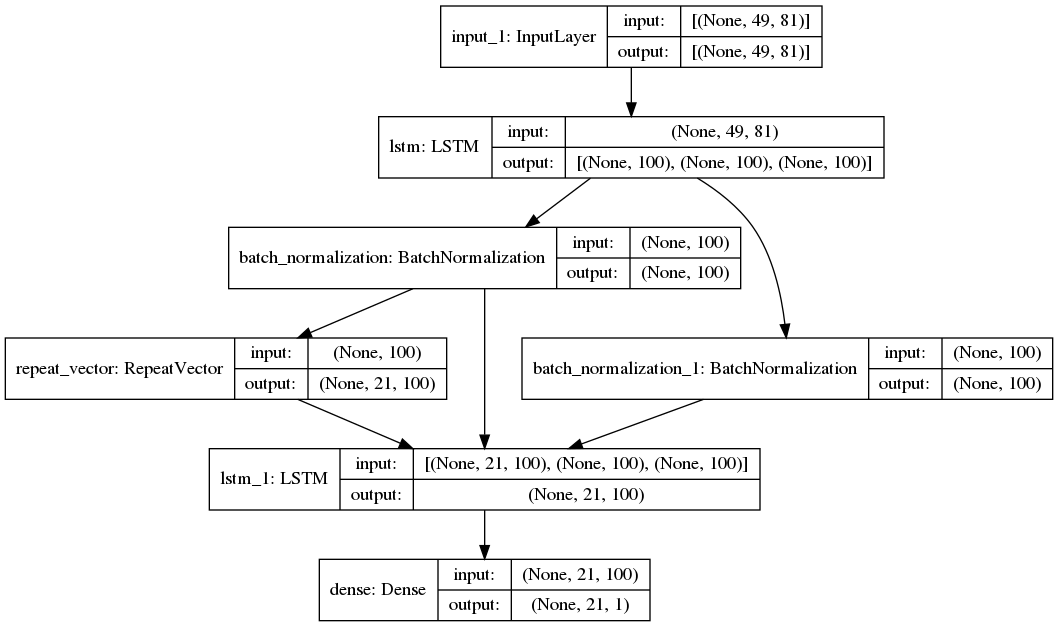

In [17]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
display(X_input_train.shape, X_output_train.shape)

(1413, 49, 82)

(1413, 21, 2)

In [19]:
#Checks on 3d array indexing
display(X_input_train[:, :, :])
display(X_input_train[:, :, :-1])

display(X_output_train[:, :, :])
display(X_output_train[:, :, :1])
display(X_output_train[:, :, :-1])

array([[[8.84043857e-01, 8.81581207e-01, 8.78460497e-01, ...,
         7.66724504e-01, 8.43668237e-01, 0.00000000e+00],
        [8.84043857e-01, 8.81581207e-01, 8.78460497e-01, ...,
         7.67688452e-01, 8.41313448e-01, 1.00000000e+00],
        [8.84043857e-01, 8.81581207e-01, 8.78460497e-01, ...,
         7.68652400e-01, 8.38958660e-01, 2.00000000e+00],
        ...,
        [7.70702605e-01, 7.63258207e-01, 7.60574811e-01, ...,
         8.11066127e-01, 7.35347985e-01, 4.60000000e+01],
        [7.81541168e-01, 7.83270596e-01, 7.64943187e-01, ...,
         8.12030075e-01, 7.32993197e-01, 4.70000000e+01],
        [7.89384864e-01, 7.83604136e-01, 7.80268309e-01, ...,
         8.12994024e-01, 7.30638409e-01, 4.80000000e+01]],

       [[8.84043857e-01, 8.81581207e-01, 8.78460497e-01, ...,
         7.67688452e-01, 8.41313448e-01, 1.00000000e+00],
        [8.84043857e-01, 8.81581207e-01, 8.78460497e-01, ...,
         7.68652400e-01, 8.38958660e-01, 2.00000000e+00],
        [8.68701274e-01, 

array([[[0.88404386, 0.88158121, 0.8784605 , ..., 0.82926165,
         0.7667245 , 0.84366824],
        [0.88404386, 0.88158121, 0.8784605 , ..., 0.82935247,
         0.76768845, 0.84131345],
        [0.88404386, 0.88158121, 0.8784605 , ..., 0.82944328,
         0.7686524 , 0.83895866],
        ...,
        [0.77070261, 0.76325821, 0.76057481, ..., 0.83343929,
         0.81106613, 0.73534799],
        [0.78154117, 0.7832706 , 0.76494319, ..., 0.83353011,
         0.81203008, 0.7329932 ],
        [0.78938486, 0.78360414, 0.78026831, ..., 0.83362092,
         0.81299402, 0.73063841]],

       [[0.88404386, 0.88158121, 0.8784605 , ..., 0.82935247,
         0.76768845, 0.84131345],
        [0.88404386, 0.88158121, 0.8784605 , ..., 0.82944328,
         0.7686524 , 0.83895866],
        [0.86870127, 0.84971649, 0.84701136, ..., 0.8295341 ,
         0.76961635, 0.83660387],
        ...,
        [0.78154117, 0.7832706 , 0.76494319, ..., 0.83353011,
         0.81203008, 0.7329932 ],
        [0.7

array([[[1.31600000e-01, 4.90000000e+01],
        [1.30957143e-01, 5.00000000e+01],
        [1.30314286e-01, 5.10000000e+01],
        ...,
        [1.23242857e-01, 6.70000000e+01],
        [1.23228571e-01, 6.80000000e+01],
        [1.23214286e-01, 6.90000000e+01]],

       [[1.30957143e-01, 5.00000000e+01],
        [1.30314286e-01, 5.10000000e+01],
        [1.29671429e-01, 5.20000000e+01],
        ...,
        [1.23228571e-01, 6.80000000e+01],
        [1.23214286e-01, 6.90000000e+01],
        [1.23200000e-01, 7.00000000e+01]],

       [[1.30314286e-01, 5.10000000e+01],
        [1.29671429e-01, 5.20000000e+01],
        [1.29028571e-01, 5.30000000e+01],
        ...,
        [1.23214286e-01, 6.90000000e+01],
        [1.23200000e-01, 7.00000000e+01],
        [1.15528571e-01, 7.10000000e+01]],

       ...,

       [[1.95142857e-02, 1.45900000e+03],
        [2.30857143e-02, 1.46000000e+03],
        [2.66571429e-02, 1.46100000e+03],
        ...,
        [1.34000000e-02, 1.47700000e+03],
     

array([[[0.1316    ],
        [0.13095714],
        [0.13031429],
        ...,
        [0.12324286],
        [0.12322857],
        [0.12321429]],

       [[0.13095714],
        [0.13031429],
        [0.12967143],
        ...,
        [0.12322857],
        [0.12321429],
        [0.1232    ]],

       [[0.13031429],
        [0.12967143],
        [0.12902857],
        ...,
        [0.12321429],
        [0.1232    ],
        [0.11552857]],

       ...,

       [[0.01951429],
        [0.02308571],
        [0.02665714],
        ...,
        [0.0134    ],
        [0.01512857],
        [0.01685714]],

       [[0.02308571],
        [0.02665714],
        [0.03022857],
        ...,
        [0.01512857],
        [0.01685714],
        [0.01858571]],

       [[0.02665714],
        [0.03022857],
        [0.0338    ],
        ...,
        [0.01685714],
        [0.01858571],
        [0.02031429]]])

array([[[0.1316    ],
        [0.13095714],
        [0.13031429],
        ...,
        [0.12324286],
        [0.12322857],
        [0.12321429]],

       [[0.13095714],
        [0.13031429],
        [0.12967143],
        ...,
        [0.12322857],
        [0.12321429],
        [0.1232    ]],

       [[0.13031429],
        [0.12967143],
        [0.12902857],
        ...,
        [0.12321429],
        [0.1232    ],
        [0.11552857]],

       ...,

       [[0.01951429],
        [0.02308571],
        [0.02665714],
        ...,
        [0.0134    ],
        [0.01512857],
        [0.01685714]],

       [[0.02308571],
        [0.02665714],
        [0.03022857],
        ...,
        [0.01512857],
        [0.01685714],
        [0.01858571]],

       [[0.02665714],
        [0.03022857],
        [0.0338    ],
        ...,
        [0.01685714],
        [0.01858571],
        [0.02031429]]])

In [32]:
X_input_train[:, :, :-1].shape, X_output_train[:, :, :-1].shape

((1413, 49, 81), (1413, 21, 1))

In [33]:
array_sum = np.sum(X_input_train)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

False


In [22]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=20)
#model.load_weights('Forecasting_seq2seq.h5')
history = model.fit(X_input_train[:, :, :-1], X_output_train[:, :, :-1], validation_split=0.2, 
                    epochs=epc, verbose=1,
                    callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('Forecasting_seq2seq.h5')

Epoch 1/100
12/12 [==============================] - 6s 138ms/step - loss: 2.6193 - mae: 0.5657 - val_loss: 0.0535 - val_mae: 0.2087
Epoch 2/100
12/12 [==============================] - 1s 65ms/step - loss: 0.0362 - mae: 0.1234 - val_loss: 0.0013 - val_mae: 0.0282
Epoch 3/100
12/12 [==============================] - 1s 69ms/step - loss: 0.0213 - mae: 0.0900 - val_loss: 1.5766 - val_mae: 1.0849
Epoch 4/100
12/12 [==============================] - 1s 68ms/step - loss: 0.0070 - mae: 0.0573 - val_loss: 0.0023 - val_mae: 0.0416
Epoch 5/100
12/12 [==============================] - 1s 78ms/step - loss: 0.0037 - mae: 0.0398 - val_loss: 7.9652e-04 - val_mae: 0.0223
Epoch 6/100
12/12 [==============================] - 1s 68ms/step - loss: 0.0020 - mae: 0.0323 - val_loss: 6.8126e-04 - val_mae: 0.0222
Epoch 7/100
12/12 [==============================] - 1s 67ms/step - loss: 0.0017 - mae: 0.0310 - val_loss: 0.0100 - val_mae: 0.0835
Epoch 8/100
12/12 [==============================] - 1s 69ms/step -

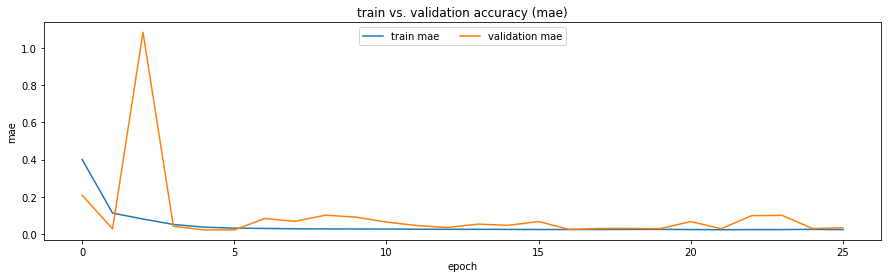

In [34]:
plt.figure(figsize=(15, 4))
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', fancybox=True, shadow=False, ncol=2)
plt.show()

# Predict

In [54]:
train_pred_detrend = model.predict(X_input_train[:, :, :-1])*x_train_max[:-1]
test_pred_detrend = model.predict(X_input_test[:, :, :-1])*x_train_max[:-1]
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = X_output_train[:, :, :-1]*x_train_max[:-1]
test_true_detrend = X_output_test[:, :, :-1]*x_train_max[:-1]
print(train_true_detrend.shape, test_true_detrend.shape)

(1413, 21, 82) (346, 21, 82)
(1413, 21, 82) (346, 21, 82)


In [55]:
#Time to add the index again
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, -1], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, -1], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, -1], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, -1], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(1413, 21, 83) (346, 21, 83)
(1413, 21, 83) (346, 21, 83)


In [56]:
# recover trend
data_final = dict()

for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0]
    dt_x2 = dt[:, :, 1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (1413, 21, 2)
train_true: (1413, 21, 2)
test_pred: (346, 21, 2)
test_true: (346, 21, 2)


In [57]:
for k in ['train_pred', 'train_true', 'test_pred', 'test_true']:
    print('maximum: {}'.format(k))
    print(data_final[k].max())

maximum: train_pred
98.40534668684006
maximum: train_true
71.017536
maximum: test_pred
92.54981067180634
maximum: test_true
83.470848


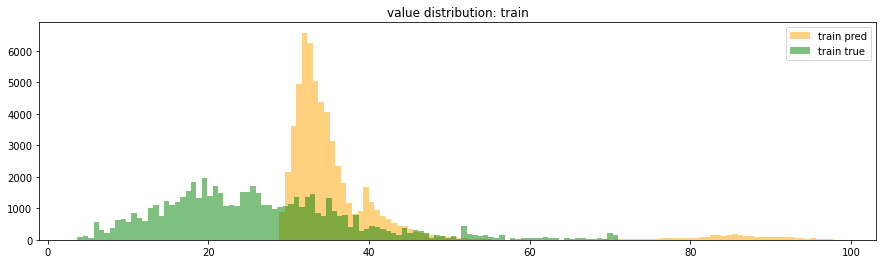

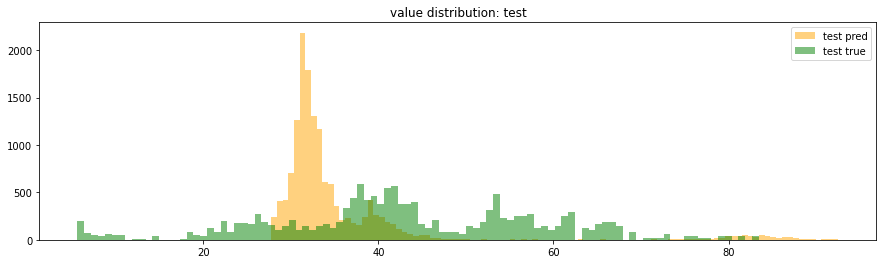

In [58]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

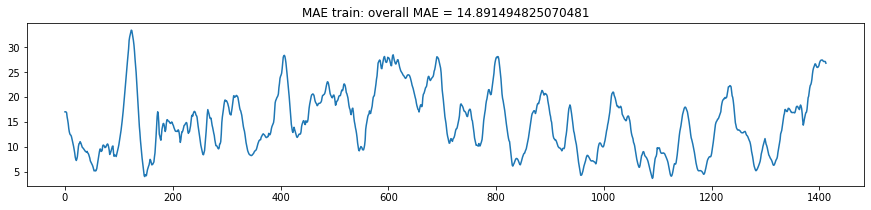

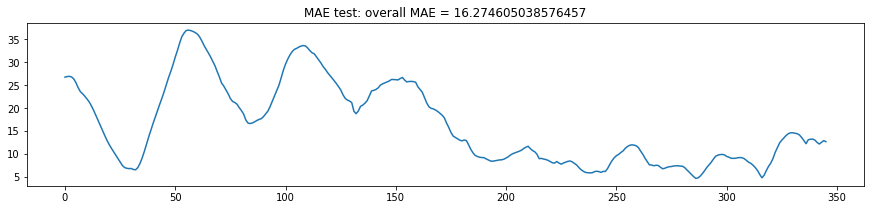

In [59]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show() 

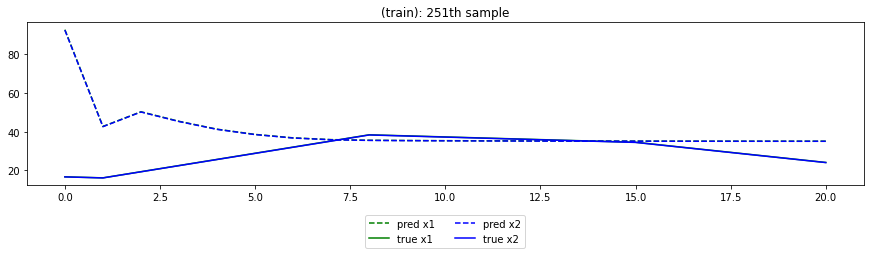

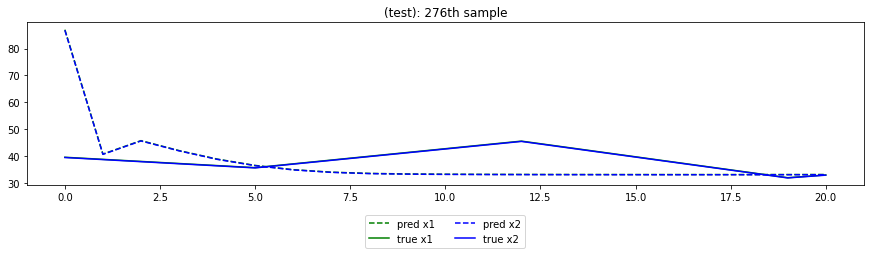

In [60]:
for lb in ['train', 'test']:
    ith_sample = random.choice(range(data_final[lb+'_pred'].shape[0]))

    plt.figure(figsize=(15,3))
    for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
        plt.plot(data_final[lb+'_pred'][ith_sample, :, i], linestyle='--', color=clr, label='pred '+x_lbl)
        plt.plot(data_final[lb+'_true'][ith_sample, :, i], linestyle='-', color=clr, label='true '+x_lbl)
    plt.title('({}): {}th sample'.format(lb, ith_sample))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()

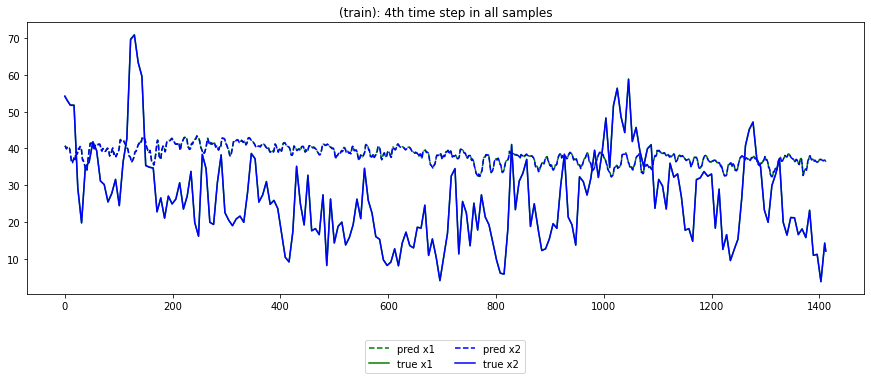

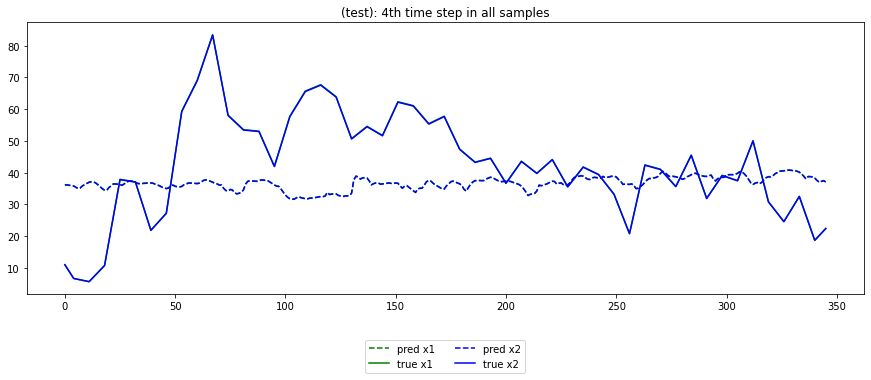

In [61]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
for lb in ['train', 'test']:   
    plt.figure(figsize=(15, 5))
    for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
        plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
        plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
    plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()


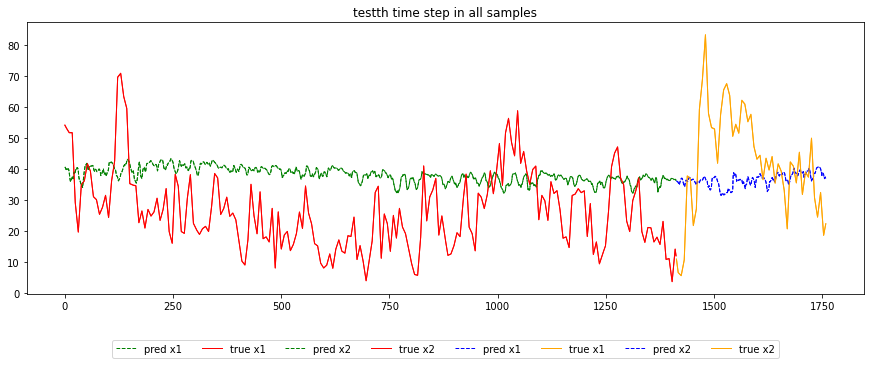

In [62]:
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
    
plt.title('{}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()